In [ ]:
# Install gradio and fetching dataset
!pip install gradio

!gdown 1RP0UJuYrHoBd2OaTDc2BSYp0ylbcP7yh
!unzip -q Dataset.zip

!gdown 1A4qUeU5AXP6NPY2WKkLyyEFNsC8eTmCd
!unzip -q archive.zip

!ls

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 762.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.6/318.6 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 7.1 MB/s eta 0:00:00
  Attempting uninstall: tomlkit
    Found existing 

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import gradio as gr
import tensorflow as tf
from tensorflow import data as tf_data
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory, image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, Input, Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG16, DenseNet121, ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_densenet
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet

In [ ]:
# Define global variables and process the dataset
image_size = (180, 180)
batch_size = 32
input_shape = (180, 180, 3)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "Lung Dataset CT 2",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/archive/Data",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)
test_ds = test_ds.prefetch(tf_data.AUTOTUNE)

Found 977 files belonging to 2 classes.
Using 782 files for training.
Using 195 files for validation.
Found 781 files belonging to 2 classes.


In [ ]:
#########################   Model Creation   #########################
# Define the create model function for pretrained models
def create_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Define the function to create an Ensemble Model
def create_ensemble_model(base_models, input_shape):
    inputs = Input(shape=input_shape)

    # Get the outputs of each base model
    outputs = [base_model(inputs) for base_model in base_models]

    # Concatenate the outputs directly
    concatenated = Concatenate()(outputs)

    # Flatten the concatenated outputs if necessary
    x = Dense(512, activation='relu')(concatenated)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=x)
    return model

#########################   Testing Helper Functions   #########################
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title(f'{title} - Training and validation accuracy')
    plt.legend(loc='lower right')
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(f'{title} - Training and validation loss')
    plt.legend(loc='upper right')
    plt.show()


#########################   Gradio Interface   #########################
def preprocess_image(image, model_name):
    image = image.resize((180, 180))
    image = np.array(image)
    if model_name == 'vgg':
        image = preprocess_vgg(image)
    elif model_name == 'densenet':
        image = preprocess_densenet(image)
    elif model_name == 'resnet':
        image = preprocess_resnet(image)
    image = np.expand_dims(image, axis=0)
    return image

def majority_vote(image):
    processed_vgg = preprocess_image(image, 'vgg')
    processed_densenet = preprocess_image(image, 'densenet')
    processed_resnet = preprocess_image(image, 'resnet')

    predictions_vgg = model_vgg.predict(processed_vgg)[0][0]
    predictions_densenet = model_densenet.predict(processed_densenet)[0][0]
    predictions_resnet = model_resnet.predict(processed_resnet)[0][0]

    # Majority voting
    votes = [predictions_vgg, predictions_densenet, predictions_resnet]
    vote = np.mean(votes)

    if vote < 0.5:
        return f"Prediction: Lung Cancer Detected (Confidence: {vote:.2f})"
    else:
        return f"Prediction: No Lung Cancer Detected (Confidence: {vote:.2f})"

########################################################

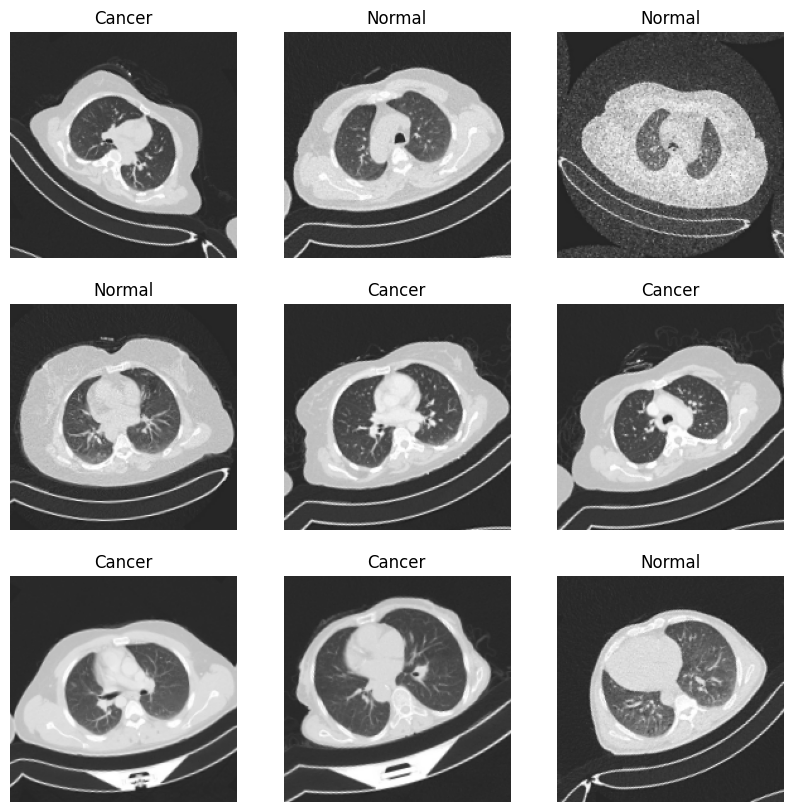

In [ ]:
# Label mapping
label_map = {0: "Cancer", 1: "Normal"}

# Example data
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(label_map[int(labels[i])])
        plt.axis("off")
    plt.show()

In [ ]:
# Load the saved models
model_vgg = load_model('vgg.keras')
model_densenet = load_model('densenet.keras')
model_resnet = load_model('resnet.keras')


In [ ]:
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(180, 180, 3))
model_vgg = create_model(base_model_vgg)
model_vgg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6), loss='binary_crossentropy', metrics=['accuracy'])


base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(180, 180, 3))
model_resnet = create_model(base_model_resnet)
model_resnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6), loss='binary_crossentropy', metrics=['accuracy'])


base_model_densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(180, 180, 3))
model_densenet = create_model(base_model_densenet)
model_densenet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6), loss='binary_crossentropy', metrics=['accuracy'])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
history_resnet = model_resnet.fit(train_ds, validation_data=val_ds, epochs=40, callbacks=[reduce_lr])

Epoch 1/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.5237 - loss: 0.7559 - val_accuracy: 0.4923 - val_loss: 0.7921 - learning_rate: 1.0000e-06
Epoch 2/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 286ms/step - accuracy: 0.6060 - loss: 0.6801 - val_accuracy: 0.5538 - val_loss: 0.6757 - learning_rate: 1.0000e-06
Epoch 3/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 324ms/step - accuracy: 0.6859 - loss: 0.5881 - val_accuracy: 0.6564 - val_loss: 0.6221 - learning_rate: 1.0000e-06
Epoch 4/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 315ms/step - accuracy: 0.6975 - loss: 0.5559 - val_accuracy: 0.7128 - val_loss: 0.5768 - learning_rate: 1.0000e-06
Epoch 5/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 300ms/step - accuracy: 0.7613 - loss: 0.5099 - val_accuracy: 0.7692 - val_loss: 0.5403 - learning_rate: 1.0000e-06
Epoch 6/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 267ms/step - accuracy: 0.7844 - loss: 0.4757 - val_accuracy: 0.8051 - val_loss: 0.5121 - learning_rate: 1.0000e-06
Epoch 7/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 321ms/step - accuracy:

In [ ]:
history_vgg = model_vgg.fit(train_ds, validation_data=val_ds, epochs=40, callbacks=[reduce_lr])

Epoch 1/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.4443 - loss: 3.1232 - val_accuracy: 0.5487 - val_loss: 0.9642 - learning_rate: 1.0000e-06
Epoch 2/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 380ms/step - accuracy: 0.5326 - loss: 1.6583 - val_accuracy: 0.7077 - val_loss: 0.5587 - learning_rate: 1.0000e-06
Epoch 3/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 406ms/step - accuracy: 0.6658 - loss: 0.9808 - val_accuracy: 0.8308 - val_loss: 0.4048 - learning_rate: 1.0000e-06
Epoch 4/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 403ms/step - accuracy: 0.6686 - loss: 0.8503 - val_accuracy: 0.8462 - val_loss: 0.3371 - learning_rate: 1.0000e-06
Epoch 5/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 389ms/step - accuracy: 0.7053 - loss: 0.6230 - val_accuracy: 0.8564 - val_loss: 0.3000 - learning_rate: 1.0000e-06
Epoch 6/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 389ms/step - accuracy: 0.8101 - loss: 0.4914 - val_accuracy: 0.8872 - val_loss: 0.2724 - learning_rate: 1.0000e-06
Epoch 7/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 399ms/step - accura

In [ ]:
history_densenet = model_densenet.fit(train_ds, validation_data=val_ds, epochs=40, callbacks=[reduce_lr])

Epoch 1/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 321s 6s/step - accuracy: 0.4700 - loss: 0.8695 - val_accuracy: 0.6000 - val_loss: 0.6612 - learning_rate: 1.0000e-06
Epoch 2/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 311ms/step - accuracy: 0.5076 - loss: 0.8566 - val_accuracy: 0.6718 - val_loss: 0.6439 - learning_rate: 1.0000e-06
Epoch 3/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 271ms/step - accuracy: 0.5977 - loss: 0.7235 - val_accuracy: 0.7231 - val_loss: 0.6169 - learning_rate: 1.0000e-06
Epoch 4/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 261ms/step - accuracy: 0.6040 - loss: 0.7139 - val_accuracy: 0.7333 - val_loss: 0.5821 - learning_rate: 1.0000e-06
Epoch 5/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 264ms/step - accuracy: 0.5836 - loss: 0.7245 - val_accuracy: 0.7590 - val_loss: 0.5446 - learning_rate: 1.0000e-06
Epoch 6/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 321ms/step - accuracy: 0.6216 - loss: 0.6445 - val_accuracy: 0.7949 - val_loss: 0.5089 - learning_rate: 1.0000e-06
Epoch 7/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 260ms/step - accuracy:

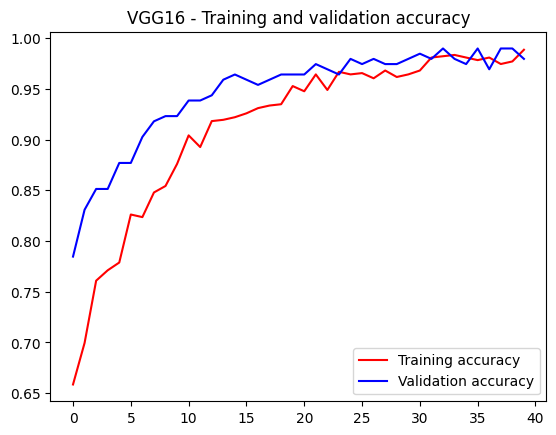

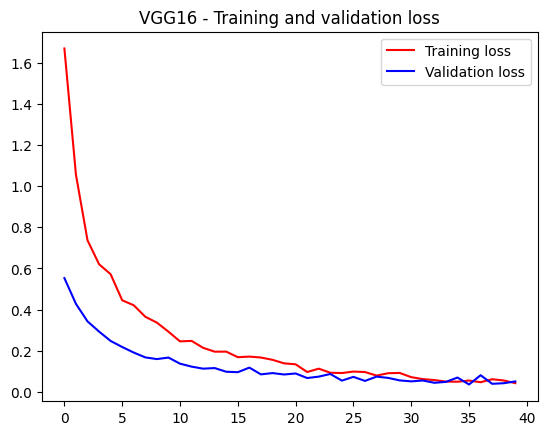

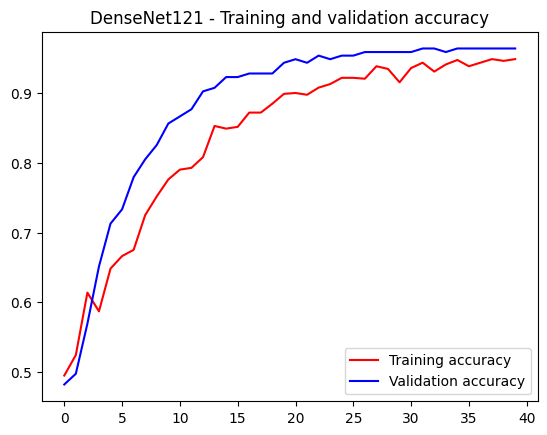

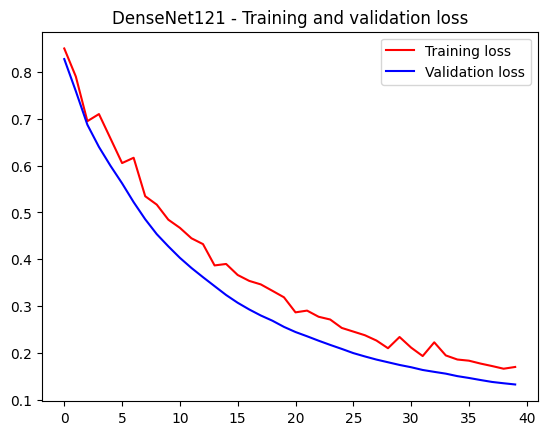

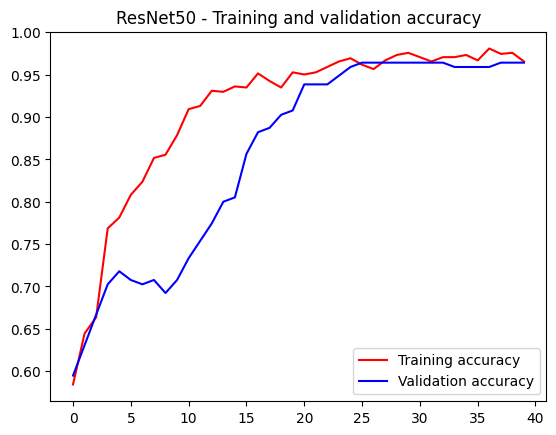

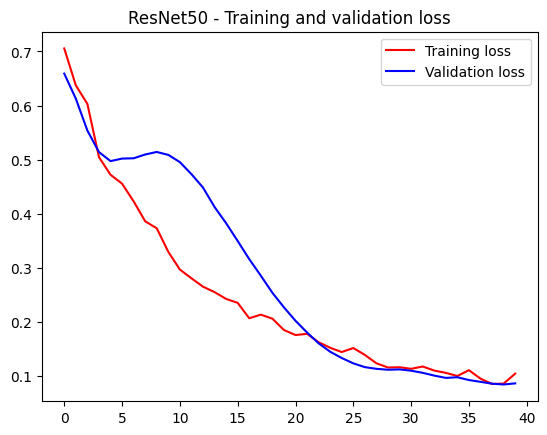

In [ ]:
plot_history(history_vgg, 'VGG16')
plot_history(history_densenet, 'DenseNet121')
plot_history(history_resnet, 'ResNet50')

In [ ]:
# Save the models
model_densenet.save('densenet.keras')
model_resnet.save('resnet.keras')
model_vgg.save('vgg.keras')

In [ ]:
# Load Stacked Model
ensemble_model = load_model('stacked.keras')

In [ ]:
# Assuming the base models are already loaded and named appropriately
base_model_vgg = model_vgg
base_model_densenet = model_densenet
base_model_resnet = model_resnet

# Create the ensemble model
base_models = [base_model_vgg, base_model_densenet, base_model_resnet]
ensemble_model = create_ensemble_model(base_models, input_shape)

# Compile the Ensemble Model
ensemble_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6), loss='binary_crossentropy', metrics=['accuracy'])

# Prepare Data Generators
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)

# Train the Ensemble Model
history = ensemble_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=35,
    callbacks=[reduce_lr]
)

Epoch 1/35
25/25 ━━━━━━━━━━━━━━━━━━━━ 458s 9s/step - accuracy: 0.4506 - loss: 0.0000e+00 - val_accuracy: 0.5385 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 2/35
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 839ms/step - accuracy: 0.5823 - loss: 0.0000e+00 - val_accuracy: 0.5385 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 3/35
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 902ms/step - accuracy: 0.5767 - loss: 0.0000e+00 - val_accuracy: 0.5385 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 4/35
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 885ms/step - accuracy: 0.6034 - loss: 0.0000e+00 - val_accuracy: 0.5385 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 5/35
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 849ms/step - accuracy: 0.6085 - loss: 0.0000e+00 - val_accuracy: 0.5385 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 6/35
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 896ms/step - accuracy: 0.5989 - loss: 0.0000e+00 - val_accuracy: 0.5385 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 7/35
2

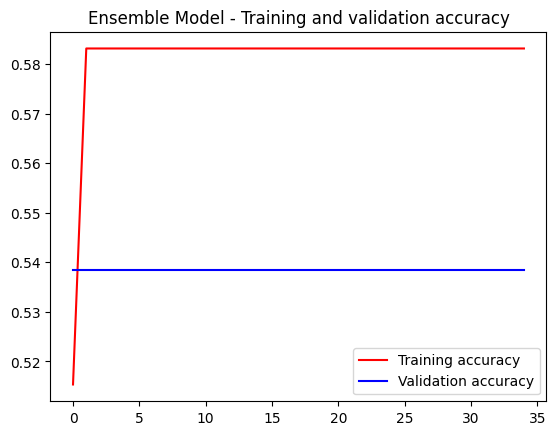

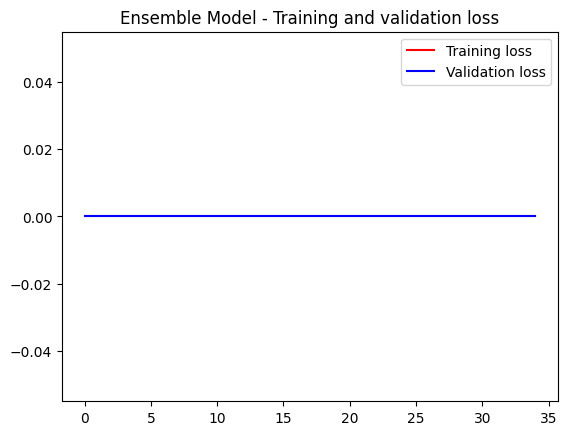

In [ ]:
plot_history(history, 'Ensemble Model')

In [ ]:
# Downloads stacked model
!gdown 1FptFBj4iCn8Z2085Dc2a7cl7gKBTSs7j
# Save Stacked Model
ensemble_model.save('stacked.keras')

In [ ]:
# Evaluate accuracy for pre-trained models
val_loss_vgg, val_acc_vgg = model_vgg.evaluate(test_ds)
print(f"Accuracy (VGG16): {val_acc_vgg:.4f}")

val_loss_dense, val_acc_dense = model_densenet.evaluate(test_ds)
print(f"Accuracy (Densenet151): {val_acc_dense:.4f}")


val_loss_resnet, val_acc_resnet = model_resnet.evaluate(test_ds)
print(f"Accuracy (resnet): {val_acc_resnet:.4f}")

# Evaluate accuracy for ensemble model
val_acc_stack = ensemble_model.evaluate(test_ds)
print(f"Accuracy (Ensemble Model): {val_acc_stack:.4f}")


25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 402ms/step - accuracy: 0.8508 - loss: 0.7334
Accuracy (VGG16): 0.8502
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 466ms/step - accuracy: 0.8335 - loss: 0.4750
Accuracy (Densenet151): 0.8182
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 302ms/step - accuracy: 0.8321 - loss: 0.4446
Accuracy (resnet): 0.8271


In [ ]:
# Gradio interface
interface = gr.Interface(fn=majority_vote, inputs=gr.Image(type="pil"), outputs=gr.Textbox())

interface.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://d32e7f168f2f34641f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
